In [1]:
from encoder import *
from decoder import *
import torchvision

In [2]:
encoder_config = VisionEncoderConfig(
    image_size=224,
    hidden_size=768,
    intermediate_size=3072,
    num_hidden_layers=12,
    num_attention_heads=12,
    num_channels=3,
    patch_size=16,
    layer_norm_eps=1e-6,
    attention_dropout=0.0,
    num_image_tokens=None,
    do_random_mask=True,
    mask_ratio=0.75
)

decoder_config = DecoderConfig(
    image_size=224,
    in_proj_dim=768,
    hidden_size=768,
    intermediate_size=3072,
    num_hidden_layers=12,
    num_attention_heads=12,
    num_channels=3,
    patch_size=16,
    layer_norm_eps=1e-6,
    attention_dropout=0.0
)

In [3]:
encoder = VisionModel(encoder_config)
decoder = Decoder(decoder_config)

same dimension size


In [4]:
img = torchvision.io.read_image("dog.jpg")
# resize image to 224x224
img = torchvision.transforms.functional.resize(img, (224, 224)).unsqueeze(0)
# normalize image
img = img / 255.0

In [5]:
img = img.repeat(2, 1, 1, 1)
img.shape

torch.Size([2, 3, 224, 224])

In [6]:
encoder_op, mask, ids_restore = encoder(img)
encoder_op.shape

torch.Size([2, 49, 768])

In [7]:
op = decoder((encoder_op, mask, ids_restore))

In [8]:
op.shape

torch.Size([2, 196, 768])

In [10]:
16 ** 2 * 3

768

In [24]:
num_mask_tokens = ids_restore.shape[1] - masked_op.shape[1]
num_mask_tokens

147

In [26]:
mask_token = nn.Parameter(torch.zeros(1, 1, 768))
mask_tokens = mask_token.repeat(2, 147, 1)

In [38]:
x = torch.cat((masked_op, mask_tokens), dim=1)
x = torch.gather(x, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, 768))
x.shape

torch.Size([2, 196, 768])

In [39]:
x

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-1.1898,  1.0640,  0.2779,  ...,  2.4618,  0.8001,  0.3451],
         [-0.1880,  1.3320, -0.8500,  ..., -0.4539,  0.0665,  0.6151],
         ...,
         [-0.5687,  0.8107, -0.9063,  ...,  1.2386,  0.0031,  0.7460],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0624,  0.9741, -1.6027,  ..., -0.7564, -1.0645,  2.4495]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0904,  1.2406, -1.7083,  ..., -0.6920, -0.8023,  2.2107]]],
       grad_fn=<GatherBackward0>)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.patch_size = config.patch_size
        self.in_chans = config.num_channels
        self.embed_dim = config.hidden_size
        self.decoder_embed = nn.Linear(self.embed_dim, self.embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, self.embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(self.embed_dim, self.embed_dim, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(self.embed_dim)
        self.decoder_pred = nn.Linear(self.embed_dim, patch_size**2 * self.in_chans, bias=True) # decoder to patch

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        num_mask_tokens = ids_restore.shape[1] - x.shape[1]  # Calculate how many mask tokens are needed
        mask_tokens = self.mask_token.repeat(x.shape[0], num_mask_tokens, 1)  # Repeat mask tokens for the batch
        x_ = torch.cat([x, mask_tokens], dim=1)  # Concatenate input tokens with mask tokens

        # unshuffle tokens to original order using ids_restore
        x = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))

        # add positional embeddings
        x = x + self.decoder_pos_embed

        return x
    

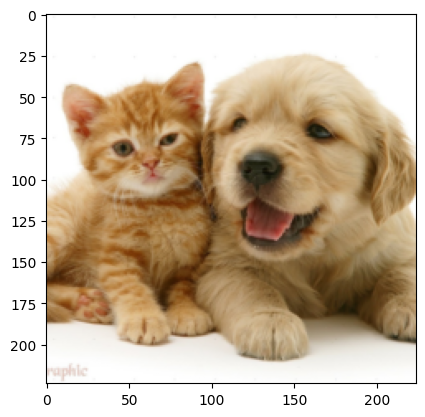

In [19]:
import matplotlib.pyplot as plt

plt.imshow(img[1].detach().cpu().permute(1, 2, 0))